In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.splirent_deconv_conv_generator_concat import load_generator_network
from definitions.predictor.splirent_only_random_regions import load_saved_predictor

import seaborn as sns

from splicing_differential_genesis_helpers import *

from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors

#Load hexamer regression weight files
nmer_weights = pd.read_csv('alt_5ss_6mers.csv', sep='\t')
nmers = list(nmer_weights.iloc[1:]['nmer'].values)

hek_w_0 = nmer_weights.iloc[0]['hek']
hek_w = np.array(nmer_weights.iloc[1:]['hek'].values)

hela_w_0 = nmer_weights.iloc[0]['hela']
hela_w = np.array(nmer_weights.iloc[1:]['hela'].values)

mcf7_w_0 = nmer_weights.iloc[0]['mcf7']
mcf7_w = np.array(nmer_weights.iloc[1:]['mcf7'].values)

cho_w_0 = nmer_weights.iloc[0]['cho']
cho_w = np.array(nmer_weights.iloc[1:]['cho'].values)

nmer_weights_1 = pd.read_csv('alt_5ss_6mers_both_regions_1.csv', sep='\t')
nmer_weights_2 = pd.read_csv('alt_5ss_6mers_both_regions_2.csv', sep='\t')

hek_both_regions_w_0 = nmer_weights_1.iloc[0]['hek']
hek_both_regions_w = np.concatenate([np.array(nmer_weights_1.iloc[1:]['hek'].values), np.array(nmer_weights_2['hek'].values)], axis=0)

hela_both_regions_w_0 = nmer_weights_1.iloc[0]['hela']
hela_both_regions_w = np.concatenate([np.array(nmer_weights_1.iloc[1:]['hela'].values), np.array(nmer_weights_2['hela'].values)], axis=0)

mcf7_both_regions_w_0 = nmer_weights_1.iloc[0]['mcf7']
mcf7_both_regions_w = np.concatenate([np.array(nmer_weights_1.iloc[1:]['mcf7'].values), np.array(nmer_weights_2['mcf7'].values)], axis=0)

cho_both_regions_w_0 = nmer_weights_1.iloc[0]['cho']
cho_both_regions_w = np.concatenate([np.array(nmer_weights_1.iloc[1:]['cho'].values), np.array(nmer_weights_2['cho'].values)], axis=0)


Using TensorFlow backend.


In [2]:

#Define target isoform loss function
def get_differential_loss(target_diff_func, region_1_start=10, region_1_end=35, region_1_target_bits=1.8, region_2_start=53, region_2_end=78, region_2_target_bits=1.8, entropy_weight=0.0, similarity_weight=0.0, similarity_margin=0.5) :
    
    masked_entropy_mse_region_1 = get_target_entropy_sme_masked(pwm_start=region_1_start, pwm_end=region_1_end, target_bits=region_1_target_bits)
    masked_entropy_mse_region_2 = get_target_entropy_sme_masked(pwm_start=region_2_start, pwm_end=region_2_end, target_bits=region_2_target_bits)
    
    pwm_sample_entropy_func_region_1 = get_pwm_margin_sample_entropy_masked(pwm_start=region_1_start, pwm_end=region_1_end, margin=similarity_margin, shift_1_nt=True)
    pwm_sample_entropy_func_region_2 = get_pwm_margin_sample_entropy_masked(pwm_start=region_2_start, pwm_end=region_2_end, margin=similarity_margin, shift_1_nt=True)
    
    def pwm_loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, hek_pred, hela_pred, mcf7_pred, cho_pred = loss_tensors
        
        #Specify costs
        diff_loss = 1.0 * K.mean(target_diff_func(hek_pred, hela_pred, mcf7_pred, cho_pred), axis=1)
        
        seq_loss = 0.0
        
        entropy_loss = entropy_weight * (masked_entropy_mse_region_1(pwm_1, mask) + masked_entropy_mse_region_2(pwm_1, mask)) / 2.
        entropy_loss += similarity_weight * (K.mean(pwm_sample_entropy_func_region_1(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1) + K.mean(pwm_sample_entropy_func_region_2(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1)) / 2.
        
        #Compute total loss
        total_loss = diff_loss + seq_loss + entropy_loss

        return total_loss
    
    def sample_loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, hek_pred, hela_pred, mcf7_pred, cho_pred = loss_tensors
        
        #Specify costs
        diff_loss = 1.0 * K.mean(target_diff_func(hek_pred, hela_pred, mcf7_pred, cho_pred), axis=1)
        
        seq_loss = 0.0
        
        entropy_loss = entropy_weight * (masked_entropy_mse_region_1(pwm_1, mask) + masked_entropy_mse_region_2(pwm_1, mask)) / 2.
        entropy_loss += similarity_weight * (K.mean(pwm_sample_entropy_func_region_1(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1) + K.mean(pwm_sample_entropy_func_region_2(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1)) / 2.
        
        #Compute total loss
        total_loss = diff_loss + seq_loss + entropy_loss

        return total_loss
    
    return pwm_loss_func, sample_loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(sequence_templates, pwm_loss_func, sample_loss_func, library_contexts, model_path, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, pwm_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=1, eval_mode='pwm')
    _, sample_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')

    for layer in pwm_predictor.layers :
        if 'splirent' in layer.name :
            layer.name += "_pwmversion"
    
    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, pwm_loss_model = build_loss_model(pwm_predictor, pwm_loss_func)
    _, sample_loss_model = build_loss_model(sample_predictor, sample_loss_func)
    
    dual_loss_out = Lambda(lambda x: 0.5 * x[0] + 0.5 * x[1])([pwm_loss_model.outputs[0], sample_loss_model.outputs[0]])

    loss_model = Model(inputs=pwm_loss_model.inputs, outputs=dual_loss_out)
    
    #Specify Optimizer to use
    #opt = keras.optimizers.SGD(lr=0.1)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    #Specify callback entities
    callbacks =[
        #EarlyStopping(monitor='loss', min_delta=0.001, patience=20, verbose=0, mode='auto'),
        #SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, cse_start_pos=70, isoform_start=target_cut, isoform_end=target_cut+1, pwm_start=70-40, pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=[0])
    ]

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)), #Dummy training example
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks
    )

    return generator, sample_predictor, train_history


In [3]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../splirent/saved_models')
saved_predictor_model_name = 'aparent_splirent_only_random_regions_drop_02_sgd.h5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)

In [4]:
#Specify sequence template and differential objective

sequence_templates = [
    'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA'
]

library_contexts = [
    'n/a'
]

target_diff_funcs = [
    lambda hek_pred, hela_pred, mcf7_pred, cho_pred: 3.0 * K.abs(K.abs(cho_pred[..., 0] - mcf7_pred[..., 0]) - 1.0)
]

cell_type_suffixes = [
    'cho_vs_mcf7'
]


In [ ]:
#Train APA Cleavage GENESIS Network

print("Training GENESIS (Diff. Splicing)")

#Number of PWMs to generate per objective
batch_size = 32
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 10
#Number of epochs per objective to optimize
n_epochs = 50
#Number of steps (grad updates) per epoch
steps_per_epoch = 500


K.clear_session()

pwm_loss_func, sample_loss_func = get_differential_loss(
    target_diff_funcs[0],
    region_1_start=10,
    region_1_end=35,
    region_1_target_bits=2.0,
    region_2_start=53,
    region_2_end=78,
    region_2_target_bits=2.0,
    entropy_weight=3.5,
    similarity_weight=7.5,
    similarity_margin=0.5,
)

genesis_generator, genesis_predictor, train_history = run_genesis([sequence_templates[0]], pwm_loss_func, sample_loss_func, [library_contexts[0]], saved_predictor_model_path, batch_size, n_samples, n_epochs, steps_per_epoch)

genesis_generator.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_2').function = lambda inp: inp

genesis_predictor.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_2').function = lambda inp: inp

# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'genesis_diff_splicing_cnn_pwm_and_multisample_' + cell_type_suffixes[0] + '_only_random_regions_50_epochs_harderentropy_retry_1_generator.h5'
model_path = os.path.join(save_dir, model_name)
genesis_generator.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = 'genesis_diff_splicing_cnn_pwm_and_multisample_' + cell_type_suffixes[0] + '_only_random_regions_50_epochs_harderentropy_retry_1_predictor.h5'
model_path = os.path.join(save_dir, model_name)
genesis_predictor.save(model_path)
print('Saved trained model at %s ' % model_path)


In [2]:
sequence_template = 'AGGTGCTTGGNNNNNNNNNNNNNNNNNNNNNNNNNGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA'

cell_type_suffix = 'cho_vs_mcf7'

model_suffix = 'only_random_regions_50_epochs_harderentropy_retry_1'


cell_1, cell_2 = cell_type_suffix.split("_vs_")
cell_type_ixs = { 'hek' : 0, 'hela' : 1, 'mcf7' : 2, 'cho' : 3, }
cell_i, cell_j = cell_type_ixs[cell_1], cell_type_ixs[cell_2]

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'genesis_diff_splicing_cnn_pwm_and_multisample_' + cell_type_suffix + '_' + model_suffix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)

generator = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'genesis_diff_splicing_cnn_pwm_and_multisample_' + cell_type_suffix + '_' + model_suffix + '_predictor.h5'
model_path = os.path.join(save_dir, model_name)

predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:

cnn_model_names = [
    'aparent_splirent_only_random_regions_drop_02_sgd',
    'aparent_splirent_only_random_regions_cuts_drop_02_sgd',
    'aparent_splirent_drop_02_sgd',
    'aparent_splirent_cuts_drop_02_sgd',
    'aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss',
    'aparent_splirent_drop_02_sgd_targeted_a5ss',
]

cnn_input_preps = [
    lambda x: [x[:, 5:40, :, 0], x[:, 48:83, :, 0]],
    lambda x: [x[:, 5:40, :, 0], x[:, 48:83, :, 0]],
    lambda x: [x[:, 5:83, :, 0]],
    lambda x: [x[:, 5:83, :, 0]],
    lambda x: [x[:, 5:40, :, 0], x[:, 48:83, :, 0]],
    lambda x: [x[:, 5:83, :, 0]],
]

save_dir = os.path.join(os.getcwd(), '../../../splirent/saved_models')

cnn_predictors = [
    load_model(os.path.join(save_dir, cnn_predictor_model_name + ".h5")) for cnn_predictor_model_name in cnn_model_names
]


CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.5012681
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.4323732
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.46516174
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.3592404
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.31241658
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.35867113
LR pred diff = 0.05910305547957029
LR pred diff (both regions) = 0.20875361616831312
Pred Diff (CNN) = 0.5


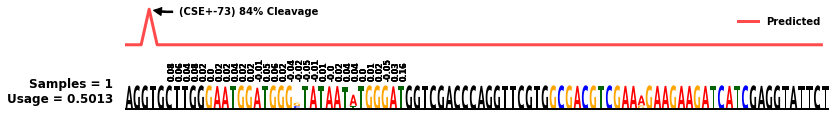

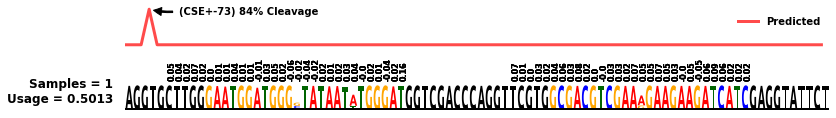

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.5742886
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.4736904
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.46904552
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.29478538
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.49121344
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.4796906
LR pred diff = 0.16972991656240421
LR pred diff (both regions) = 0.4455910224229065
Pred Diff (CNN) = 0.57


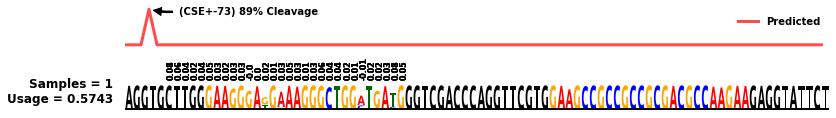

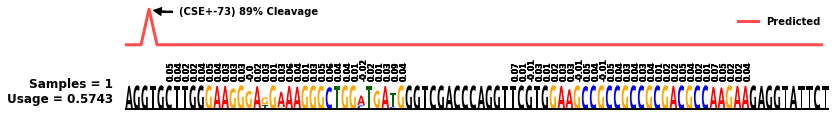

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.5679256
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.37798876
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.5701195
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.35666054
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.43392628
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.37592474
LR pred diff = 0.12866710822888983
LR pred diff (both regions) = 0.37036482979293694
Pred Diff (CNN) = 0.57


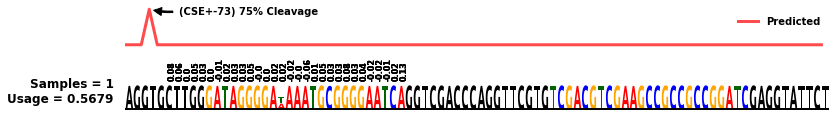

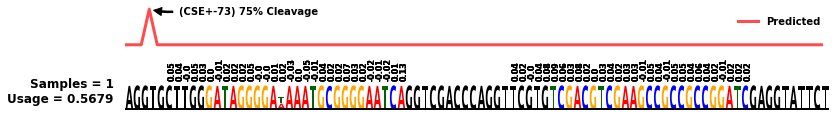

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.61397195
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.2889319
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.5845956
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.38530976
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.4205253
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.38909486
LR pred diff = 0.21848872285437348
LR pred diff (both regions) = 0.4718211361452337
Pred Diff (CNN) = 0.61


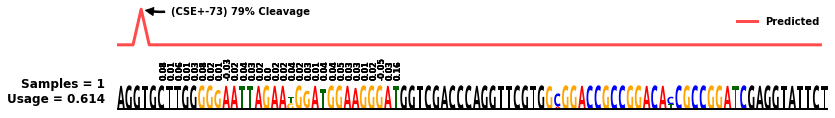

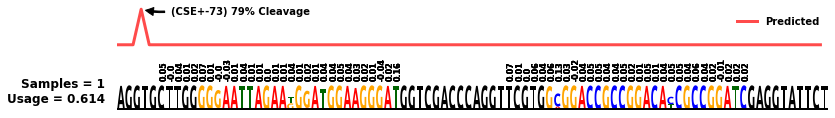

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.614061
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.4405817
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.60460556
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.3838872
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.41584322
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.39490306
LR pred diff = 0.34436430728027906
LR pred diff (both regions) = 0.5249164633663276
Pred Diff (CNN) = 0.61


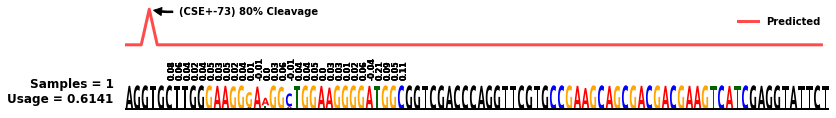

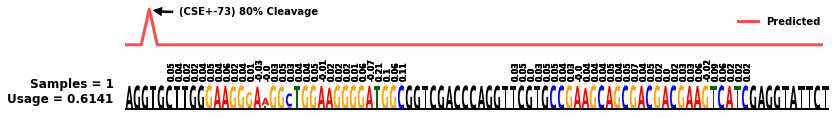

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.62279975
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.35589844
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.56741446
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.37397346
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.3964944
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.34718573
LR pred diff = 0.3172499257207352
LR pred diff (both regions) = 0.49572413711655205
Pred Diff (CNN) = 0.62


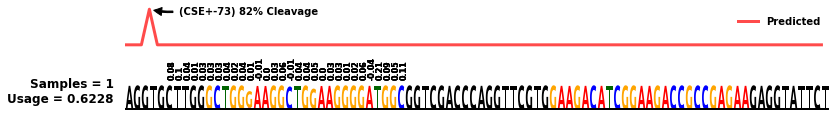

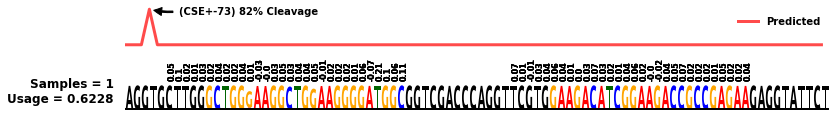

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.585675
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.38964123
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.5588456
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.39219007
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.49907863
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.40234122
LR pred diff = 0.19916904542085534
LR pred diff (both regions) = 0.4938218943522867
Pred Diff (CNN) = 0.59


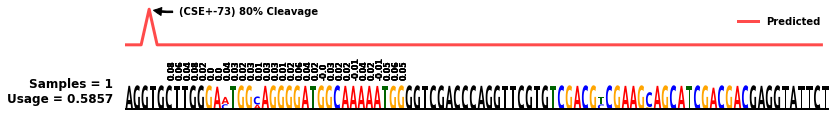

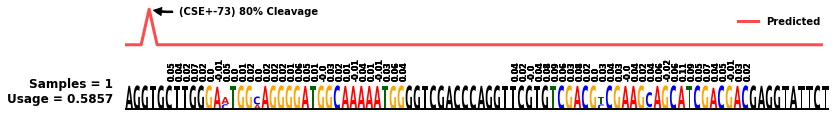

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.56663203
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.4141609
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.5789615
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.41442475
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.49523368
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.37184748
LR pred diff = 0.25546324477684956
LR pred diff (both regions) = 0.3956081756713082
Pred Diff (CNN) = 0.57


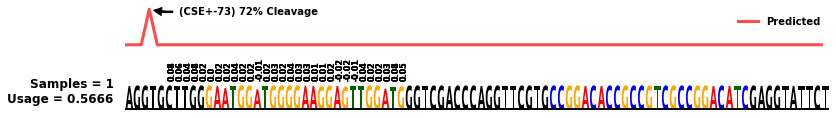

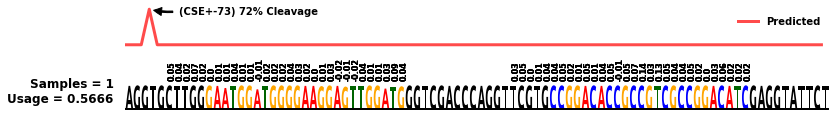

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.5140774
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.447376
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.46980453
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.3415478
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.49596745
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.377833
LR pred diff = 0.2461130509424837
LR pred diff (both regions) = 0.4786700093562393
Pred Diff (CNN) = 0.51


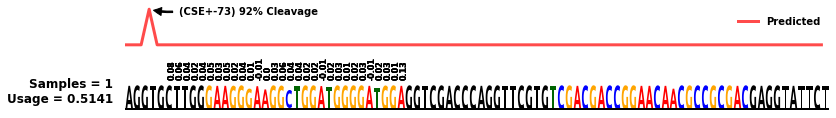

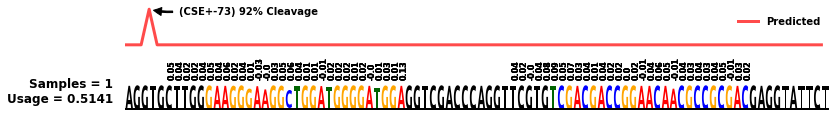

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.5997564
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.44055712
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.5284235
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.35503423
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.5179508
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.46181437
LR pred diff = 0.18823676355403374
LR pred diff (both regions) = 0.4125022612137452
Pred Diff (CNN) = 0.6


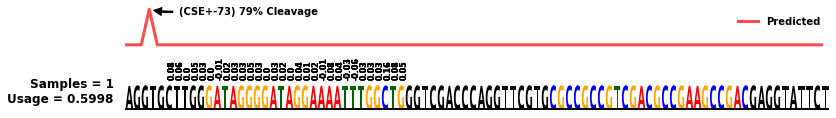

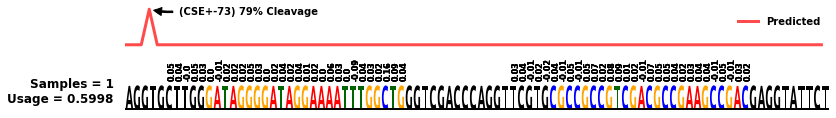

In [5]:
#Make 10 randomly sampled sequence predictions

n = 32

sequence_class = np.array([0] * n).reshape(-1, 1)

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=32)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _, hek_pred, hela_pred, mcf7_pred, cho_pred = pred_outputs

onehots = sampled_pwm[:, 0, :, :, :]

iso_pred = np.concatenate([hek_pred, hela_pred, mcf7_pred, cho_pred], axis=-1)

cut_pred = np.zeros((n, 1, 109))
cut_pred[:, 0, 3] = iso_pred[:, 0, cell_i]

diff_pred = iso_pred[:, :, cell_i] - iso_pred[:, :, cell_j]

cnn_preds = [
    cnn_predictors[i].predict(x=cnn_input_preps[i](onehots), batch_size=32) for i in range(len(cnn_predictors))
]

cnn_diffs = [
    (cnn_preds[i][cell_i] - cnn_preds[i][cell_j]) for i in range(len(cnn_predictors))
]

lr_preds = get_hexamer_preds(decode_onehots_consensus(onehots))
lr_both_regions_preds = get_hexamer_preds_both_regions(decode_onehots_consensus(onehots))

lr_diffs = lr_preds[:, cell_i] - lr_preds[:, cell_j]
lr_both_regions_diffs = lr_both_regions_preds[:, cell_i] - lr_both_regions_preds[:, cell_j]

for pwm_index in range(10) :
    
    pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cut_pred[pwm_index, 0, :], axis=0)
    diff = np.expand_dims(diff_pred[pwm_index, :], axis=-1)
    
    for i in range(len(cnn_predictors)) :
        print("CNN Model = " + str(cnn_model_names[i]) + ", pred diff = " + str(cnn_diffs[i][pwm_index, 0]))
    
    print("LR pred diff = " + str(lr_diffs[pwm_index]))
    print("LR pred diff (both regions) = " + str(lr_both_regions_diffs[pwm_index]))
    
    print("Pred Diff (CNN) = " + str(round(diff[0, 0], 2)))
    
    hexamer_diffs_both_regions = get_hexamer_diff_scores_both_regions(decode_onehot_consensus(optimized_pwm[pwm_index, :, :, 0]), cell_1, cell_2)
    hexamer_diffs = get_hexamer_diff_scores(decode_onehot_consensus(optimized_pwm[pwm_index, :, :, 0]), cell_1, cell_2)
    
    plot_logo_w_hexamer_scores(pwm, diff, cut, hexamer_diffs, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.75), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=88, save_figs=False, fig_name="diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_pwm_index_" + str(pwm_index), fig_dpi=150)
    plot_logo_w_hexamer_scores(pwm, diff, cut, hexamer_diffs_both_regions, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.75), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=88, save_figs=False, fig_name="diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_pwm_index_" + str(pwm_index), fig_dpi=150)

N Sequences = 10
Number of unique sequences = 10
Duplication rate = 0.0
N Sequences = 100
Number of unique sequences = 100
Duplication rate = 0.0
N Sequences = 1000
Number of unique sequences = 1000
Duplication rate = 0.0
N Sequences = 10000
Number of unique sequences = 9941
Duplication rate = 0.0059
N Sequences = 100000
Number of unique sequences = 95962
Duplication rate = 0.0404


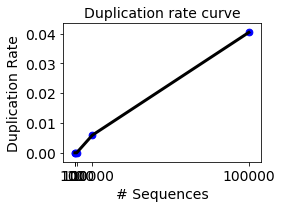

In [52]:
#Estimate duplication rates

def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus

save_figs = False

f = plt.figure(figsize=(4, 3))

n_sequences_large_list = [10, 100, 1000, 10000, 100000]
dup_rates = []

for n_sequences_large in n_sequences_large_list :
    n_sequences_ceil_large = int(n_sequences_large / 32) * 32 + 32

    print("N Sequences = " + str(n_sequences_large))

    sequence_class = np.array([0] * n_sequences_ceil_large).reshape(-1, 1)

    noise_1 = np.random.uniform(-1, 1, (n_sequences_ceil_large, 100))
    noise_2 = np.random.uniform(-1, 1, (n_sequences_ceil_large, 100))

    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=32)

    _, _, _, optimized_pwm_large, _, sampled_pwm_large, _, _, _, _, _, _, _ = pred_outputs

    onehots_large = sampled_pwm_large[:, 0, :, :, :]


    consensus_seqs_large = []

    for i in range(onehots_large.shape[0]) :
        consensus_seqs_large.append(get_consensus_sequence(onehots_large[i, :, :, 0]))

    consensus_seqs_large = np.array(consensus_seqs_large, dtype=np.object)

    #Sample first n_sequences
    onehots_large_kept = onehots_large[:n_sequences_large, :, :]
    consensus_large_seqs_kept = consensus_seqs_large[:n_sequences_large]

    n_unique_seqs_kept = len(np.unique(consensus_large_seqs_kept))

    print("Number of unique sequences = " + str(n_unique_seqs_kept))
    
    dup_rate = 1. - n_unique_seqs_kept / n_sequences_large
    dup_rates.append(dup_rate)
    
    print("Duplication rate = " + str(round(dup_rate, 4)))


plt.plot(n_sequences_large_list, dup_rates, linewidth=3, linestyle='-', color='black')
plt.scatter(n_sequences_large_list, dup_rates, c='blue', s=45)

plt.xlabel("# Sequences", fontsize=14)
plt.ylabel("Duplication Rate", fontsize=14)
plt.xticks(n_sequences_large_list, fontsize=14)
plt.yticks(fontsize=14)

plt.title("Duplication rate curve", fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig("diff_splicing_dup_rate_curve.eps")
    plt.savefig("diff_splicing_dup_rate_curve.svg")
    plt.savefig("diff_splicing_dup_rate_curve.png", transparent=True, dpi=150)

plt.show()


In [15]:
#Generate 3,200 sequences

n = 32 * 100

sequence_class = np.array([0] * n).reshape(-1, 1)

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=32)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _, hek_pred, hela_pred, mcf7_pred, cho_pred = pred_outputs

onehots = sampled_pwm[:, 0, :, :, :]

iso_pred = np.concatenate([hek_pred, hela_pred, mcf7_pred, cho_pred], axis=-1)

cut_pred = np.zeros((n, 1, 109))
cut_pred[:, 0, 3] = iso_pred[:, 0, cell_i]

diff_pred = iso_pred[:, :, cell_i] - iso_pred[:, :, cell_j]


CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.6749063
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.38757557
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.6421565
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.35918367
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.5207026
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.37310323
LR pred diff = 0.3206341277368266
LR pred diff (both regions) = 0.5000712051393021
Pred Diff (CNN) = 0.67


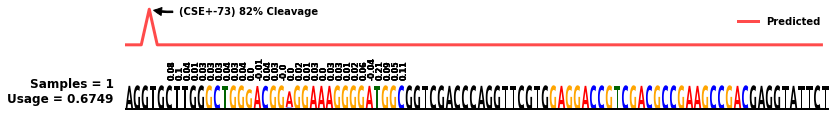

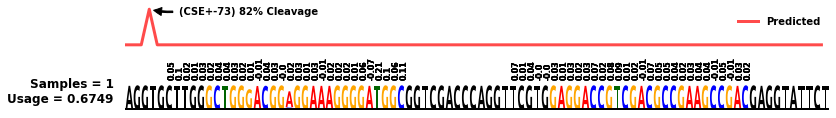

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.6724522
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.42015702
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.63285863
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.3131444
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.5348816
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.35232076
LR pred diff = 0.3206341277368266
LR pred diff (both regions) = 0.523401637298428
Pred Diff (CNN) = 0.67


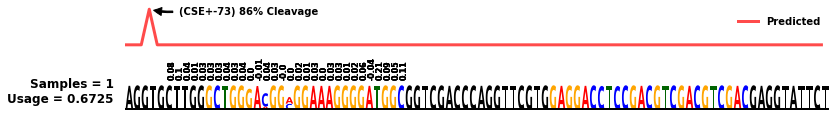

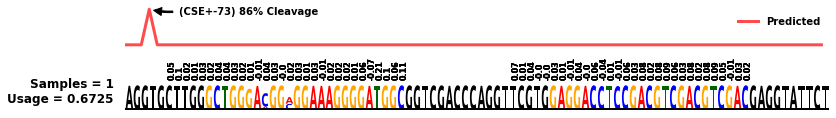

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.66596675
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.4278178
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.62656915
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.38080502
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.5116166
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.2464048
LR pred diff = 0.3206341277368266
LR pred diff (both regions) = 0.5655252275301479
Pred Diff (CNN) = 0.67


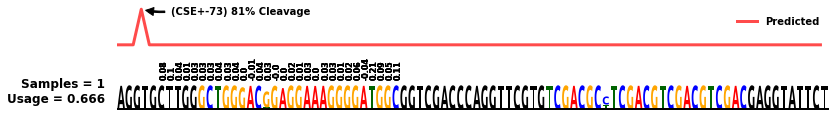

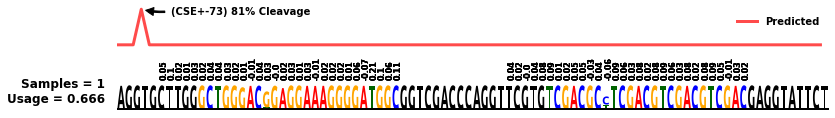

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.6635782
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.3294563
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.5879773
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.22266462
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.4463703
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.32531476
LR pred diff = 0.3206341277368266
LR pred diff (both regions) = 0.4648650825317183
Pred Diff (CNN) = 0.66


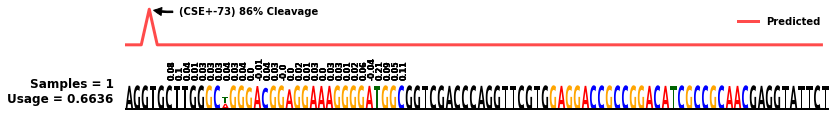

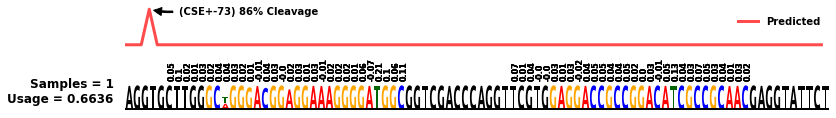

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.6625102
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.3216666
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.56972575
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.27708206
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.4738116
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.38678524
LR pred diff = 0.3270472267322259
LR pred diff (both regions) = 0.501814987918401
Pred Diff (CNN) = 0.66


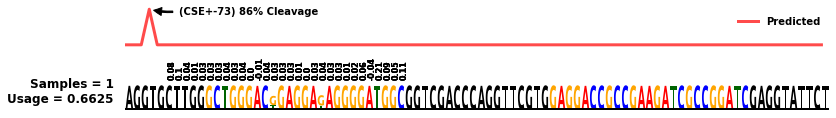

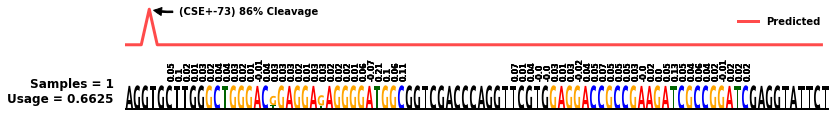

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.6619471
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.26716807
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.5792303
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.3119277
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.4984378
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.31847292
LR pred diff = 0.2835235888240142
LR pred diff (both regions) = 0.44850717698263787
Pred Diff (CNN) = 0.66


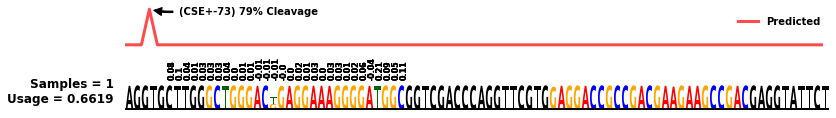

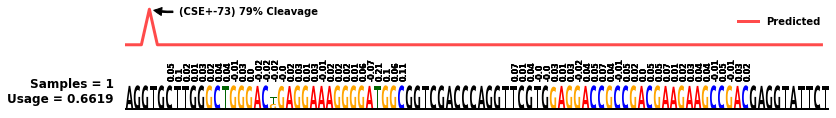

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.6609738
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.34411165
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.57306457
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.31849197
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.33313274
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.26848862
LR pred diff = 0.3206341277368266
LR pred diff (both regions) = 0.4832592820549756
Pred Diff (CNN) = 0.66


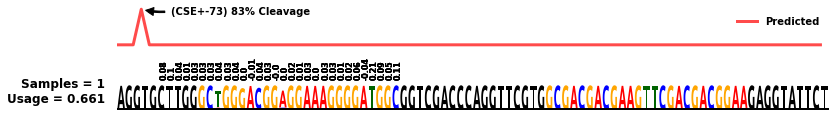

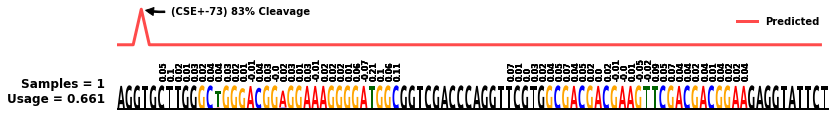

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.65872633
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.44763002
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.6239478
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.38836014
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.4686852
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.26506346
LR pred diff = 0.3206341277368266
LR pred diff (both regions) = 0.48365494552679006
Pred Diff (CNN) = 0.66


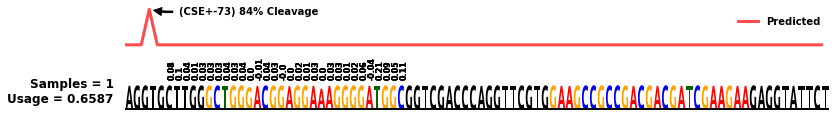

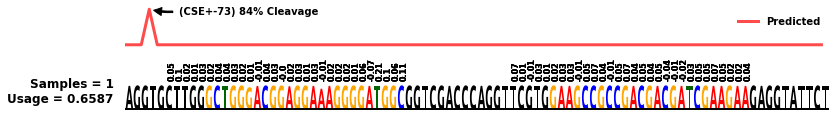

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.6568908
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.34268185
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.6107591
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.30866444
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.40326786
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.3617913
LR pred diff = 0.33043641550321984
LR pred diff (both regions) = 0.4021449419294014
Pred Diff (CNN) = 0.66


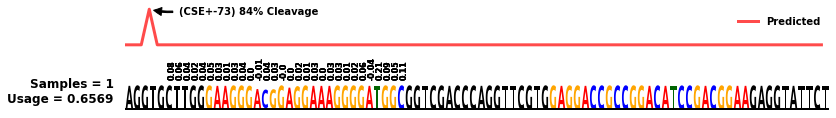

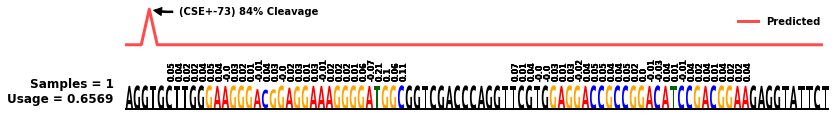

CNN Model = aparent_splirent_only_random_regions_drop_02_sgd, pred diff = 0.65592146
CNN Model = aparent_splirent_only_random_regions_cuts_drop_02_sgd, pred diff = 0.42534524
CNN Model = aparent_splirent_drop_02_sgd, pred diff = 0.6282975
CNN Model = aparent_splirent_cuts_drop_02_sgd, pred diff = 0.3449294
CNN Model = aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss, pred diff = 0.4736444
CNN Model = aparent_splirent_drop_02_sgd_targeted_a5ss, pred diff = 0.3586934
LR pred diff = 0.3206341277368266
LR pred diff (both regions) = 0.45627938413642
Pred Diff (CNN) = 0.66


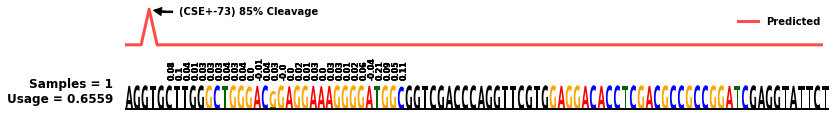

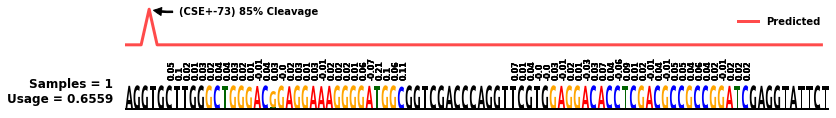

In [5]:
#Sort and plot top 10 sequences

sort_index = np.argsort(np.abs(diff_pred[:, 0]))[::-1]
keep_index = sort_index[:10]

optimized_pwm_kept = optimized_pwm[keep_index]
onehots_kept = onehots[keep_index]
iso_pred_kept = iso_pred[keep_index]
cut_pred_kept = cut_pred[keep_index]
diff_pred_kept = diff_pred[keep_index]


cnn_preds = [
    cnn_predictors[i].predict(x=cnn_input_preps[i](onehots_kept), batch_size=32) for i in range(len(cnn_predictors))
]

cnn_diffs = [
    (cnn_preds[i][cell_i] - cnn_preds[i][cell_j]) for i in range(len(cnn_predictors))
]

lr_preds = get_hexamer_preds(decode_onehots_consensus(onehots_kept))
lr_both_regions_preds = get_hexamer_preds_both_regions(decode_onehots_consensus(onehots_kept))

lr_diffs = lr_preds[:, cell_i] - lr_preds[:, cell_j]
lr_both_regions_diffs = lr_both_regions_preds[:, cell_i] - lr_both_regions_preds[:, cell_j]

for pwm_index in range(10) :
    
    pwm = np.expand_dims(optimized_pwm_kept[pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cut_pred_kept[pwm_index, 0, :], axis=0)
    diff = np.expand_dims(diff_pred_kept[pwm_index, :], axis=-1)
    
    for i in range(len(cnn_predictors)) :
        print("CNN Model = " + str(cnn_model_names[i]) + ", pred diff = " + str(cnn_diffs[i][pwm_index, 0]))
    
    print("LR pred diff = " + str(lr_diffs[pwm_index]))
    print("LR pred diff (both regions) = " + str(lr_both_regions_diffs[pwm_index]))
    
    print("Pred Diff (CNN) = " + str(round(diff[0, 0], 2)))
    
    hexamer_diffs_both_regions = get_hexamer_diff_scores_both_regions(decode_onehot_consensus(optimized_pwm_kept[pwm_index, :, :, 0]), cell_1, cell_2)
    hexamer_diffs = get_hexamer_diff_scores(decode_onehot_consensus(optimized_pwm_kept[pwm_index, :, :, 0]), cell_1, cell_2)
    
    plot_logo_w_hexamer_scores(pwm, diff, cut, hexamer_diffs, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.75), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=88, save_figs=False, fig_name="top_diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_pwm_index_" + str(pwm_index), fig_dpi=150)
    plot_logo_w_hexamer_scores(pwm, diff, cut, hexamer_diffs_both_regions, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.75), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=88, save_figs=False, fig_name="top_diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_pwm_index_" + str(pwm_index), fig_dpi=150)

In [4]:
#Load test set MPRA data
pred_df = pd.read_csv('a5ss_test_pred_aparent_splirent_only_random_regions_drop_02_sgd.csv', sep='\t')


Mean MPRA Pred SD1 Diff = 0.0818
Std MPRA Pred SD1 Diff = 0.0734
Mean GENESIS Pred SD1 Diff = 0.5643
Std GENESIS Pred SD1 Diff = 0.067


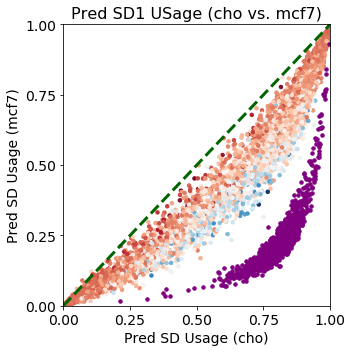

In [7]:
#Plot generated sequence dPSIs (across cell types) together with MPRA sequences

save_figs = False

mean_mpra_diff_pred = np.mean(pred_df['sd1_pred_' + cell_1] - pred_df['sd1_pred_' + cell_2])
std_mpra_diff_pred = np.std(pred_df['sd1_pred_' + cell_1] - pred_df['sd1_pred_' + cell_2])

mean_genesis_diff_pred = np.mean(iso_pred[:1000, 0, cell_i] - iso_pred[:1000, 0, cell_j])
std_genesis_diff_pred = np.std(iso_pred[:1000, 0, cell_i] - iso_pred[:1000, 0, cell_j])

print("Mean MPRA Pred SD1 Diff = " + str(round(mean_mpra_diff_pred, 4)))
print("Std MPRA Pred SD1 Diff = " + str(round(std_mpra_diff_pred, 4)))
print("Mean GENESIS Pred SD1 Diff = " + str(round(mean_genesis_diff_pred, 4)))
print("Std GENESIS Pred SD1 Diff = " + str(round(std_genesis_diff_pred, 4)))


f = plt.figure(figsize=(5, 5))

min_delta = np.min(pred_df['sd1_true_' + cell_2] - pred_df['sd1_true_' + cell_1])
max_delta = np.max(pred_df['sd1_true_' + cell_2] - pred_df['sd1_true_' + cell_1])
max_abs_delta = np.abs(np.max(pred_df['sd1_true_' + cell_2] - pred_df['sd1_true_' + cell_1]))

plt.scatter(pred_df['sd1_pred_' + cell_1], pred_df['sd1_pred_' + cell_2], c=pred_df['sd1_true_' + cell_2] - pred_df['sd1_true_' + cell_1], cmap='RdBu_r', vmin=min_delta, vmax=max_delta, s=12, alpha=0.95)

plt.plot([0, 1], [0, 1], color='darkgreen', linewidth=3, linestyle='--')

#Plot optimized dots
plt.scatter(iso_pred[:1000, 0, cell_i], iso_pred[:1000, 0, cell_j], c='purple', s=12, alpha=1.0)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel('Pred SD Usage (' + cell_1 + ')', fontsize=14)
plt.ylabel('Pred SD Usage (' + cell_2 + ')', fontsize=14)
plt.title('Pred SD1 USage (' + cell_1 + ' vs. ' + cell_2 +')', fontsize=16)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()

if save_figs :
    fig_name = "diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_pred_scatter"
    plt.savefig(fig_name + ".png", transparent=True, dpi=150)
    plt.savefig(fig_name + ".eps")
    plt.savefig(fig_name + ".svg")

plt.show()

In [21]:
#Evaluate Sequence diversity

def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus

n_sequences = 1000

consensus_seqs = []

for i in range(onehots.shape[0]) :
    consensus_seqs.append(get_consensus_sequence(onehots[i, :, :, 0]))

consensus_seqs = np.array(consensus_seqs, dtype=np.object)

#Sample first n_sequences
onehots_kept = onehots[:n_sequences, :, :]
consensus_seqs_kept = consensus_seqs[:n_sequences]

print("Number of unique sequences = " + str(len(np.unique(consensus_seqs_kept))))

#Calculate average/std nucleotide entropy

nt_entropies = []
for j in range(onehots_kept.shape[1]) :
    if sequence_template[j] == 'N' :
        
        p_A = np.sum(onehots_kept[:, j, 0, 0]) / n_sequences
        p_C = np.sum(onehots_kept[:, j, 1, 0]) / n_sequences
        p_G = np.sum(onehots_kept[:, j, 2, 0]) / n_sequences
        p_T = np.sum(onehots_kept[:, j, 3, 0]) / n_sequences
        
        nt_entropy = 0
        if p_A * p_C * p_G * p_T > 0. :
            nt_entropy = - (p_A * np.log2(p_A) + p_C * np.log2(p_C) + p_G * np.log2(p_G) + p_T * np.log2(p_T))
        
        nt_entropies.append(nt_entropy)

nt_entropies = np.array(nt_entropies)

print("Mean NT Entropy = " + str(round(np.mean(nt_entropies), 4)))
print("Std NT Entropy = " + str(round(np.std(nt_entropies), 4)))


Number of unique sequences = 1000
Mean NT Entropy = 1.2799
Std NT Entropy = 0.7038


In [48]:
#Calculate hexamer entropies

hexamer_encoder = isol.NMerEncoder(n_mer_len=6, count_n_mers=True)

hexamers = isol.SparseBatchEncoder(encoder=hexamer_encoder)(consensus_seqs_kept)

print(hexamers.shape)

hexamer_sum = np.ravel(hexamers.sum(axis=0))

hexamers_probs = hexamer_sum / np.sum(hexamer_sum)

n_nonzero_hexamers = len(np.nonzero(hexamer_sum > 0)[0])

print("Number of unique hexamers = " + str(n_nonzero_hexamers))


hexamer_entropy = -1. * np.sum(hexamers_probs[hexamer_sum > 0] * np.log2(hexamers_probs[hexamer_sum > 0]))

print("Hexamer Entropy = " + str(hexamer_entropy))


#Calculate average/std hexamer entropy

nonzero_index = np.nonzero(hexamer_sum > 0)[0]

hexamer_entropies = []
for j in range(n_nonzero_hexamers) :
    p_on = len(np.nonzero(hexamers[:, nonzero_index[j]] > 0)[0]) / hexamers.shape[0]
    p_off = 1. - p_on

    hexamer_entropy = 0
    if p_on * p_off > 0. :
        hexamer_entropy = -(p_on * np.log2(p_on) + p_off * np.log2(p_off))

    hexamer_entropies.append(hexamer_entropy)

hexamer_entropies = np.array(hexamer_entropies)

print("Mean Binary Hexamer Entropy = " + str(round(np.mean(hexamer_entropies), 4)))
print("Std Binary Hexamer Entropy = " + str(round(np.std(hexamer_entropies), 4)))


(1000, 4096)
Number of unique hexamers = 1550
Hexamer Entropy = 8.310330572602869
Mean Binary Hexamer Entropy = 0.1554
Std Binary Hexamer Entropy = 0.2179


In [53]:
#Load splicing usage predictor

save_dir_path = '../../../splirent/saved_models'

model_path = os.path.join(save_dir_path, 'aparent_splirent_only_random_regions_drop_02_sgd' + '.h5')
splicing_model = load_model(model_path)


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [54]:
#Create a new model that outputs the conv layer activation maps together with the isoform proportion

dense_out_model = Model(
    inputs = splicing_model.inputs,
    outputs = [
        splicing_model.get_layer('dropout_1').output
    ]
)


In [55]:
#Load splicing MPRA dataset

def iso_normalizer(t) :
    iso = 0.0
    if np.sum(t) > 0.0 :
        iso = t[0] / np.sum(t)
    
    return iso

def cut_normalizer(t) :
    cuts = np.concatenate([np.zeros(100), np.array([1.0])])
    if np.sum(t) > 0.0 :
        cuts = t / np.sum(t)
    
    return cuts

#Create nearest neighbor search database

#Load plasmid data
plasmid_dict = pickle.load(open('../../../splirent/data/a5ss/processed_data/' + 'alt_5ss_data.pickle', 'rb'))

valid_set_size = 10000
test_set_size = 10000

#Generate training and test set indexes
plasmid_index = np.arange(len(plasmid_dict['min_df']), dtype=np.int)

if valid_set_size < 1.0 and test_set_size < 1.0 :
    train_index = plasmid_index[:-int(len(plasmid_dict['min_df']) * (valid_set_size + test_set_size))]
    valid_index = plasmid_index[train_index.shape[0]:-int(len(plasmid_dict['min_df']) * test_set_size)]
    test_index = plasmid_index[train_index.shape[0] + valid_index.shape[0]:]
else :
    train_index = plasmid_index[:-int(valid_set_size + test_set_size)]
    valid_index = plasmid_index[train_index.shape[0]:-int(test_set_size)]
    test_index = plasmid_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


seq_start_1 = 147
seq_start_2 = 147 + 25 + 18
splice_donor_pos = 140

sequence_padding = 5

splicing_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {
            'df' : plasmid_dict['min_df'],
            'hek_count' : plasmid_dict['min_hek_count'],
            'hela_count' : plasmid_dict['min_hela_count'],
            'mcf7_count' : plasmid_dict['min_mcf7_count'],
            'cho_count' : plasmid_dict['min_cho_count'],
        },
        batch_size=len(idx),#32,
        inputs = [
            {
                'id' : 'random_region_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, seq_start_1=seq_start_1, seq_start_2=seq_start_2, sequence_padding=sequence_padding: row['padded_seq'][seq_start_1 - sequence_padding: seq_start_1 + 25 + sequence_padding],
                'encoder' : iso.OneHotEncoder(seq_length=25 + 2 * sequence_padding),
                'dim' : (25 + 2 * sequence_padding, 4),
                'sparsify' : False
            },
            {
                'id' : 'random_region_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, seq_start_1=seq_start_1, seq_start_2=seq_start_2, sequence_padding=sequence_padding: row['padded_seq'][seq_start_2 - sequence_padding: seq_start_2 + 25 + sequence_padding],
                'encoder' : iso.OneHotEncoder(seq_length=25 + 2 * sequence_padding),
                'dim' : (25 + 2 * sequence_padding, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : cell_type + '_sd1_usage',
                'source_type' : 'matrix',
                'source' : cell_type + '_count',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=True),
                'transformer' : lambda t: iso_normalizer(t),
                'dim' : (1,)
            } for cell_type in ['hek', 'hela', 'mcf7', 'cho']
        ] + [
            {
                'id' : cell_type + '_count',
                'source_type' : 'matrix',
                'source' : cell_type + '_count',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=True),
                'transformer' : lambda t: np.sum(t),
                'dim' : (1,)
            } for cell_type in ['hek', 'hela', 'mcf7', 'cho']
        ],
        randomizers = [],
        shuffle = False,
        densify_batch_matrices=False,
    ) for gen_id, idx in [('all', plasmid_index), ('train', train_index), ('valid', valid_index), ('test', test_index)]
}


Training set size = 244647
Validation set size = 10000
Test set size = 10000


In [56]:
#Apply generator on MPRA data

[onehots_up, onehots_dn], [hek_true, hela_true, mcf7_true, cho_true, hek_count, hela_count, mcf7_count, cho_count] = splicing_gens['all'][0]


In [57]:

#Filter dataset

keep_index = np.nonzero((mcf7_count >= 30) & (cho_count >= 30))[0]

onehots_up_kept = onehots_up[keep_index]
onehots_dn_kept = onehots_dn[keep_index]

hek_true_kept = hek_true[keep_index]
hela_true_kept = hela_true[keep_index]
mcf7_true_kept = mcf7_true[keep_index]
cho_true_kept = cho_true[keep_index]

hek_count_kept = hek_count[keep_index]
hela_count_kept = hela_count[keep_index]
mcf7_count_kept = mcf7_count[keep_index]
cho_count_kept = cho_count[keep_index]


In [58]:
#Compute neural network dense layer activations on MPRA

library_dense_out_kept = dense_out_model.predict(x=[onehots_up_kept, onehots_dn_kept], batch_size=32)

print(library_dense_out_kept.shape)


(201673, 256)


In [59]:
#Fit nearest neighbor databases on MPRA

nn_dense_mcf7_10 = KNeighborsRegressor(n_neighbors=10).fit(library_dense_out_kept, mcf7_true_kept)
nn_dense_cho_10 = KNeighborsRegressor(n_neighbors=10).fit(library_dense_out_kept, cho_true_kept)

nn_dense_50 = NearestNeighbors(n_neighbors=50).fit(library_dense_out_kept)


In [62]:
#Get 10-nn interpolated splice donor usage predictions of the generated sequences

input_prep_func = lambda x: [x[:, 5:40, :, 0], x[:, 48:83, :, 0]]

gen_dense_out = dense_out_model.predict(x=input_prep_func(onehots), batch_size=32)

nn_dense_mcf7_pred_10 = nn_dense_mcf7_10.predict(gen_dense_out)
nn_dense_cho_pred_10 = nn_dense_cho_10.predict(gen_dense_out)


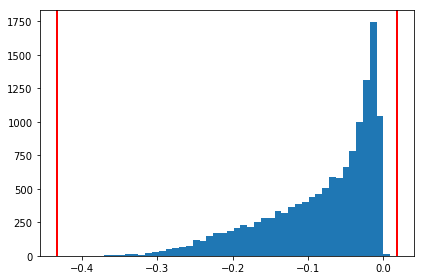

In [63]:
#Histogram of cell-type dPSIs

min_delta = np.min(pred_df['sd1_pred_' + cell_2] - pred_df['sd1_pred_' + cell_1])
max_delta = np.max(pred_df['sd1_pred_' + cell_2] - pred_df['sd1_pred_' + cell_1])
max_abs_delta = np.abs(np.max(pred_df['sd1_pred_' + cell_2] - pred_df['sd1_pred_' + cell_1]))

f = plt.figure(figsize=(6, 4))

plt.hist(pred_df['sd1_pred_' + cell_2] - pred_df['sd1_pred_' + cell_1], bins=50)

plt.axvline(x=min_delta, color='red', linewidth=2)
plt.axvline(x=max_delta, color='red', linewidth=2)

plt.tight_layout()
plt.show()


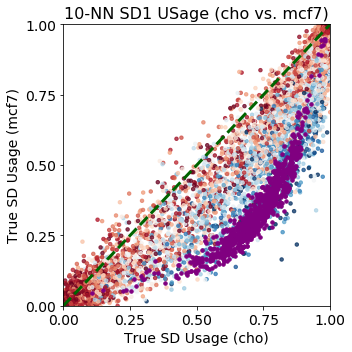

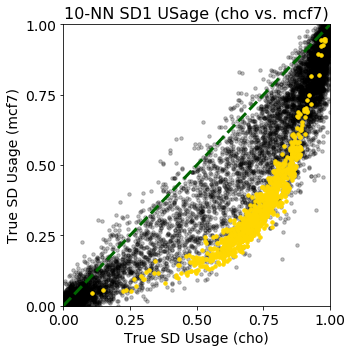

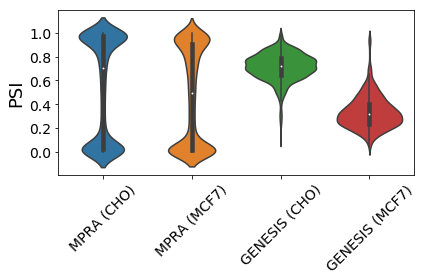

Mean MPRA True SD1 Diff = 0.0682
Std MPRA True SD1 Diff = 0.0935
Mean GENESIS NN SD1 Diff = 0.3793
Std GENESIS NN SD1 Diff = 0.0648


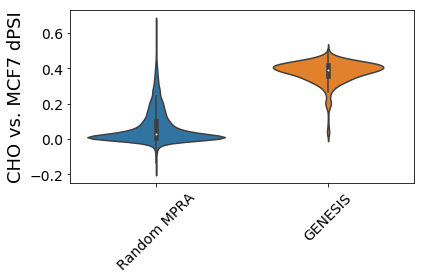

In [64]:
#Plot cell type dPSI scatters and violins, together with MPRA test set

save_figs = False

f = plt.figure(figsize=(5, 5))

min_delta = np.min(pred_df['sd1_pred_' + cell_2] - pred_df['sd1_pred_' + cell_1])
max_delta = np.max(pred_df['sd1_pred_' + cell_2] - pred_df['sd1_pred_' + cell_1])
max_abs_delta = np.abs(np.max(pred_df['sd1_pred_' + cell_2] - pred_df['sd1_pred_' + cell_1]))

min_delta = -0.3
max_delta = -0.01

plt.scatter(pred_df['sd1_true_' + cell_1], pred_df['sd1_true_' + cell_2], c=pred_df['sd1_pred_' + cell_2] - pred_df['sd1_pred_' + cell_1], cmap='RdBu_r', vmin=min_delta, vmax=max_delta, s=12, alpha=0.75)

plt.plot([0, 1], [0, 1], color='darkgreen', linewidth=3, linestyle='--')

plt.scatter(nn_dense_cho_pred_10[:1000, 0], nn_dense_mcf7_pred_10[:1000, 0], c='purple', s=12, alpha=1.0)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel('True SD Usage (' + cell_1 + ')', fontsize=14)
plt.ylabel('True SD Usage (' + cell_2 + ')', fontsize=14)
plt.title('10-NN SD1 USage (' + cell_1 + ' vs. ' + cell_2 +')', fontsize=16)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()

if save_figs :
    fig_name = "diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_true_nn_scatter_test"    
    plt.savefig(fig_name + ".png", transparent=True, dpi=150)
    plt.savefig(fig_name + ".eps")
    plt.savefig(fig_name + ".svg")

plt.show()



f = plt.figure(figsize=(5, 5))

plt.scatter(pred_df['sd1_true_' + cell_1], pred_df['sd1_true_' + cell_2], c='black', s=12, alpha=0.25)

plt.plot([0, 1], [0, 1], color='darkgreen', linewidth=3, linestyle='--')

#Plot optimized dots
#plt.scatter(iso_pred[:1000, 0, cell_i], iso_pred[:1000, 0, cell_j], c='purple', s=12, alpha=1.0)

plt.scatter(nn_dense_cho_pred_10[:1000, 0], nn_dense_mcf7_pred_10[:1000, 0], c='gold', s=12, alpha=1.0)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel('True SD Usage (' + cell_1 + ')', fontsize=14)
plt.ylabel('True SD Usage (' + cell_2 + ')', fontsize=14)
plt.title('10-NN SD1 USage (' + cell_1 + ' vs. ' + cell_2 +')', fontsize=16)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()

if save_figs :
    fig_name = "diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_true_nn_scatter_black_test"    
    plt.savefig(fig_name + ".png", transparent=True, dpi=150)
    plt.savefig(fig_name + ".eps")
    plt.savefig(fig_name + ".svg")

plt.show()


#Plot violins of 10-NN interpolated dPSIs across cell types

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=[
    np.ravel(pred_df['sd1_true_' + cell_1].values),
    np.ravel(pred_df['sd1_true_' + cell_2].values),
    nn_dense_cho_pred_10[:1000, 0],
    nn_dense_mcf7_pred_10[:1000, 0]
], axis=0)

plt.xticks(np.arange(4), ['MPRA (CHO)', 'MPRA (MCF7)', 'GENESIS (CHO)', 'GENESIS (MCF7)'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylabel('PSI', fontsize=18)

plt.tight_layout()

if save_figs :
    fig_name = "diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_true_nn_psi_violin_test"    
    plt.savefig(fig_name + ".png", transparent=True, dpi=150)
    plt.savefig(fig_name + ".eps")
    plt.savefig(fig_name + ".svg")

plt.show()


dpsi_mpra = np.ravel((pred_df['sd1_true_' + cell_1] - pred_df['sd1_true_' + cell_2].values))
dpsi_genesis = nn_dense_cho_pred_10[:1000, 0] - nn_dense_mcf7_pred_10[:1000, 0]

print("Mean MPRA True SD1 Diff = " + str(round(np.mean(dpsi_mpra), 4)))
print("Std MPRA True SD1 Diff = " + str(round(np.std(dpsi_mpra), 4)))
print("Mean GENESIS NN SD1 Diff = " + str(round(np.mean(dpsi_genesis), 4)))
print("Std GENESIS NN SD1 Diff = " + str(round(np.std(dpsi_genesis), 4)))

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=[dpsi_mpra, dpsi_genesis], axis=0)

plt.xticks(np.arange(2), ['Random MPRA', 'GENESIS'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylabel('CHO vs. MCF7 dPSI', fontsize=18)

plt.tight_layout()

if save_figs :
    fig_name = "diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_true_nn_dpsi_violin_test"    
    plt.savefig(fig_name + ".png", transparent=True, dpi=150)
    plt.savefig(fig_name + ".eps")
    plt.savefig(fig_name + ".svg")

plt.show()





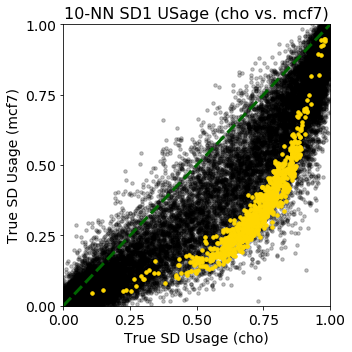

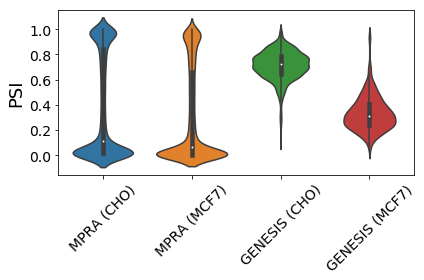

Mean MPRA True SD1 Diff = 0.0667
Std MPRA True SD1 Diff = 0.1009
Mean GENESIS NN SD1 Diff = 0.3793
Std GENESIS NN SD1 Diff = 0.0648


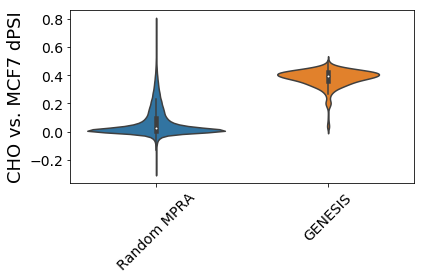

In [65]:
#Plot cell type dPSI scatters and violins, together with entire MPRA data (min total count = 50)

save_figs = False

min_count = 50

filter_index = np.nonzero((cho_count_kept >= min_count) & (mcf7_count_kept >= min_count))[0]


f = plt.figure(figsize=(5, 5))

plt.scatter(cho_true_kept[filter_index, 0], mcf7_true_kept[filter_index, 0], c='black', s=12, alpha=0.25)

plt.plot([0, 1], [0, 1], color='darkgreen', linewidth=3, linestyle='--')

plt.scatter(nn_dense_cho_pred_10[:1000, 0], nn_dense_mcf7_pred_10[:1000, 0], c='gold', s=12, alpha=1.0)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel('True SD Usage (' + cell_1 + ')', fontsize=14)
plt.ylabel('True SD Usage (' + cell_2 + ')', fontsize=14)
plt.title('10-NN SD1 USage (' + cell_1 + ' vs. ' + cell_2 +')', fontsize=16)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()

if save_figs :
    fig_name = "diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_true_nn_scatter_black"    
    plt.savefig(fig_name + ".png", transparent=True, dpi=150)
    plt.savefig(fig_name + ".eps")
    plt.savefig(fig_name + ".svg")

plt.show()


#Plot violins of 10-NN interpolated cell type dPSIs

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=[
    cho_true_kept[filter_index, 0],
    mcf7_true_kept[filter_index, 0],
    nn_dense_cho_pred_10[:1000, 0],
    nn_dense_mcf7_pred_10[:1000, 0]
], axis=0)

plt.xticks(np.arange(4), ['MPRA (CHO)', 'MPRA (MCF7)', 'GENESIS (CHO)', 'GENESIS (MCF7)'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylabel('PSI', fontsize=18)

plt.tight_layout()

if save_figs :
    fig_name = "diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_true_nn_psi_violin"    
    plt.savefig(fig_name + ".png", transparent=True, dpi=150)
    plt.savefig(fig_name + ".eps")
    plt.savefig(fig_name + ".svg")

plt.show()


dpsi_mpra = np.ravel(cho_true_kept[filter_index, 0] - mcf7_true_kept[filter_index, 0])
dpsi_genesis = nn_dense_cho_pred_10[:1000, 0] - nn_dense_mcf7_pred_10[:1000, 0]

print("Mean MPRA True SD1 Diff = " + str(round(np.mean(dpsi_mpra), 4)))
print("Std MPRA True SD1 Diff = " + str(round(np.std(dpsi_mpra), 4)))
print("Mean GENESIS NN SD1 Diff = " + str(round(np.mean(dpsi_genesis), 4)))
print("Std GENESIS NN SD1 Diff = " + str(round(np.std(dpsi_genesis), 4)))

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=[dpsi_mpra, dpsi_genesis], axis=0)

plt.xticks(np.arange(2), ['Random MPRA', 'GENESIS'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylabel('CHO vs. MCF7 dPSI', fontsize=18)

plt.tight_layout()

if save_figs :
    fig_name = "diff_splicing_genesis_" + cell_type_suffix + "_" + model_suffix + "_true_nn_dpsi_violin"    
    plt.savefig(fig_name + ".png", transparent=True, dpi=150)
    plt.savefig(fig_name + ".eps")
    plt.savefig(fig_name + ".svg")

plt.show()


